In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import glob
import geopandas as gpd
from p_tqdm import p_map
import cartopy.crs as ccrs
import cartopy
import cartopy.feature as cfeature
from matplotlib import gridspec
import matplotlib as mpl

/work/xinchenhe_umass_edu/.conda/envs/laketemp/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Load data

In [2]:
# load cci lakes
cci_lake_list = pd.read_csv("../data/cci_lakes_hydrolake_depth.csv")["CCI ID"].to_numpy()
cci_lake_list = cci_lake_list[cci_lake_list != 2226] # remove lake 2226
lakes_with_clz = pd.read_csv("../data/lakes_with_climate_zone.csv", index_col = 0).loc[cci_lake_list]
cci_lakes = pd.read_csv("../data/ESA_CCI_static_lake_mask_v2_1km_UoR_metadata_fv2.1_06Oct2021_4laketemp.csv", index_col=0).loc[cci_lake_list]
cci_lakes = pd.concat([cci_lakes, lakes_with_clz.loc[:,["climate_zone"]]], axis = 1)
cci_lakes_gdf = gpd.GeoDataFrame(cci_lakes, geometry=gpd.points_from_xy(cci_lakes['LON CENTRE'], cci_lakes['LAT CENTRE']),
                                crs="epsg:4326")
cci_lakes_gdf.index.name = "cci_lake_id"

In [3]:
# change here to replace with cloud gapped lake surface water temperature for calibration
df_tw = pd.read_csv("/nas/cee-hydro/laketemp_bias/era5land/water_temp.csv", index_col=0, 
                    parse_dates=True).loc[:, cci_lake_list.astype(str)]
ice_lake_ids = df_tw.min(axis = 0).loc[df_tw.min(axis = 0) <= 0].index.to_numpy().astype(int)
ice_lake_ids

array([ 3114,  2516, 12262, ...,   141,   212,   170])

In [4]:
# stats for observation
train_stats_obs = pd.read_csv("../data/obs_stats_train.csv", index_col = 0)
val_stats_obs = pd.read_csv("../data/obs_stats_val.csv", index_col = 0)
total_stats_obs = pd.read_csv("../data/obs_stats_total.csv", index_col = 0)

# stats for simulations
train_stats = pd.read_csv("../data/sim_stats_trainperiod_ensemble_mean.csv", index_col = 0)
val_stats = pd.read_csv("../data/sim_stats_valperiod_ensemble_mean.csv", index_col = 0)
total_stats = pd.read_csv("../data/sim_stats_totalperiod_ensemble_mean.csv", index_col = 0)

In [5]:
# Full Model bias: prediction - observation
total_stats["a2w_bias_mean"] = total_stats["a2w_mean"] - total_stats_obs["obs_mean"]
total_stats["a2w_bias_warmest_mean"] = total_stats["a2w_warmest_mean"] - total_stats_obs["obs_warmest_mean"]
total_stats["a2w_bias_ice_duration"] = total_stats["a2w_ice_days_076"] - total_stats_obs["obs_ice_duration"]
total_stats["lstm_bias_mean"] = total_stats["lstm_mean"] - total_stats_obs["obs_mean"]
total_stats["lstm_bias_warmest_mean"] = total_stats["lstm_warmest_mean"] - total_stats_obs["obs_warmest_mean"]
total_stats["lstm_bias_ice_duration"] = total_stats["lstm_ice_days_076"] - total_stats_obs["obs_ice_duration"]

In [6]:
# Sat Model bias: prediction - observation
total_stats["a2w_satbias_mean"] = total_stats["a2w_diff_mean"] + total_stats["a2w_bias_mean"]
total_stats["a2w_satbias_warmest_mean"] = total_stats["a2w_diff_warmest_mean"] + total_stats["a2w_bias_warmest_mean"]
total_stats["a2w_satbias_ice_duration"] = total_stats["a2w_diff_ice_days_076"] + total_stats["a2w_bias_ice_duration"]
total_stats["lstm_satbias_mean"] = total_stats["lstm_diff_mean"] + total_stats["lstm_bias_mean"]
total_stats["lstm_satbias_warmest_mean"] = total_stats["lstm_diff_warmest_mean"] + total_stats["lstm_bias_warmest_mean"]
total_stats["lstm_satbias_ice_duration"] = total_stats["lstm_diff_ice_days_076"] + total_stats["lstm_bias_ice_duration"]

In [47]:
stats_gdf_total.loc[338, ["lstm_satbias_warmest_mean", "lstm_bias_warmest_mean"]]

lstm_satbias_warmest_mean   -1.944283
lstm_bias_warmest_mean       0.000134
Name: 338, dtype: object

In [48]:
stats_gdf_total.loc[338, ["a2w_satbias_warmest_mean", "a2w_bias_warmest_mean"]]

a2w_satbias_warmest_mean   -0.978236
a2w_bias_warmest_mean      -0.649824
Name: 338, dtype: object

In [51]:
stats_gdf_total.loc[300012946, ["lstm_satbias_ice_duration", "lstm_bias_ice_duration"]]

lstm_satbias_ice_duration   -45.185714
lstm_bias_ice_duration       -0.504762
Name: 300012946, dtype: object

In [52]:
stats_gdf_total.loc[300012946, ["a2w_satbias_ice_duration", "a2w_bias_ice_duration", "NAME", "COUNTRY"]]

a2w_satbias_ice_duration             24.885714
a2w_bias_ice_duration                13.519048
NAME                                 Chukhloma
COUNTRY                     Russian Federation
Name: 300012946, dtype: object

In [7]:
# remove lake 2226 because it dries out
stats_gdf_total = gpd.GeoDataFrame(pd.concat([cci_lakes_gdf, total_stats], axis = 1))

# 1. Air2water

/tmp/ipykernel_4108137/989241269.py:108: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()  # leave space for colorbars


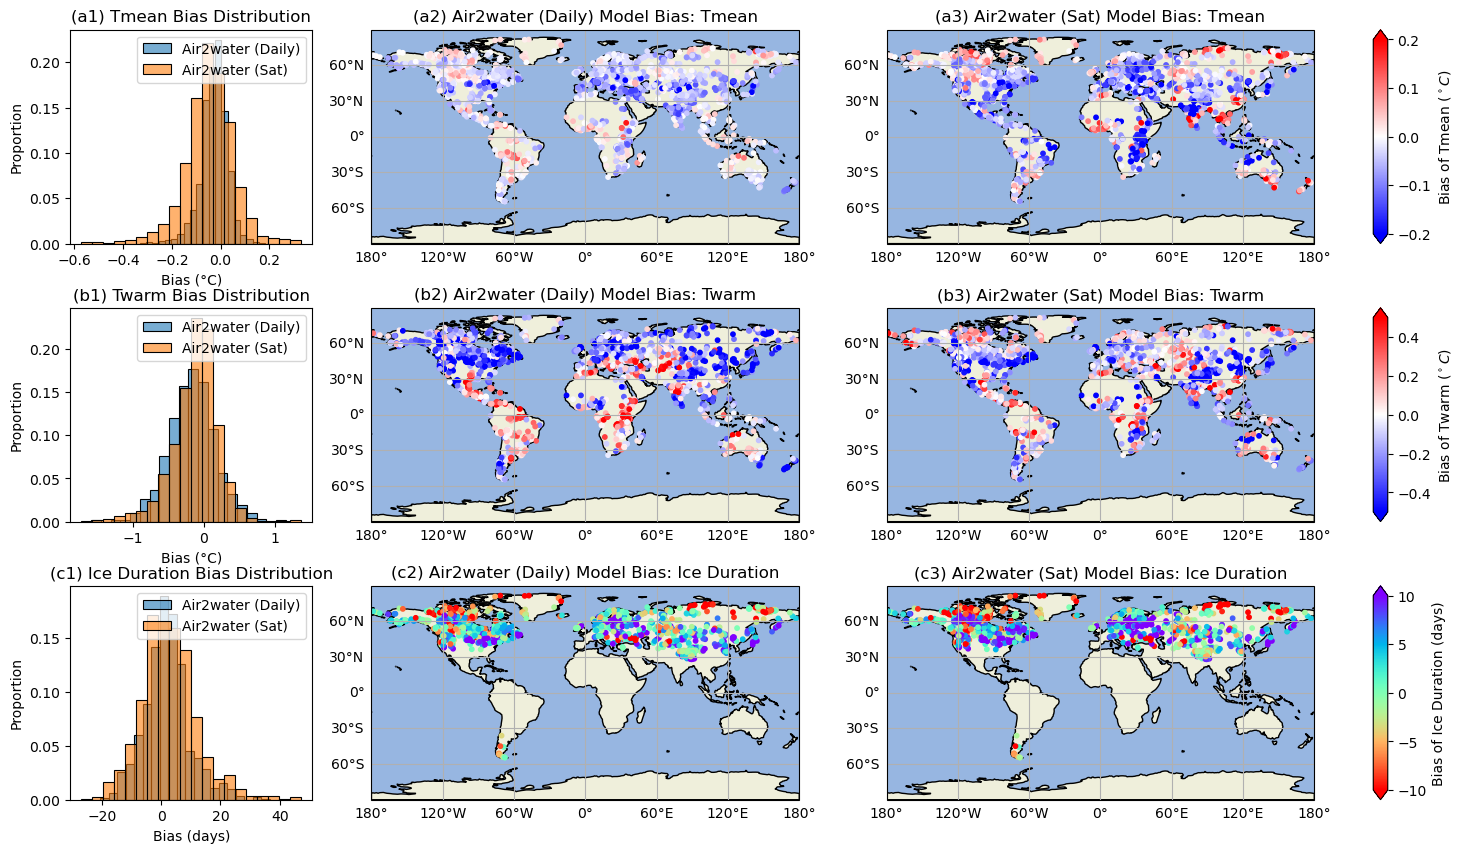

In [37]:
fig = plt.figure(figsize=(17, 10))
nt_proj = ccrs.PlateCarree()

# Reproject once
stats_gdf_total = stats_gdf_total.to_crs(nt_proj)

# GridSpec layout: 3 rows (Tmean, Twarm, Tcold), 3 columns (histogram, map1, map2)
gs = gridspec.GridSpec(3, 4, width_ratios=[0.5, 1, 1, 0.03], height_ratios=[1, 1, 1], wspace=0.1, hspace=0.3)

# Helper for maps
def add_map(ax, column, cmap, vmin, vmax, title, lake_ids=cci_lake_list):
    ax.add_feature(cartopy.feature.OCEAN, zorder=0)
    ax.add_feature(cartopy.feature.LAND, zorder=0, edgecolor='black')
    ax.set_global()
    gl = ax.gridlines(crs=nt_proj, draw_labels=True)
    gl.top_labels = False
    gl.right_labels = False
    stats_gdf_total.loc[lake_ids].dropna(subset=[column]).plot(
        column=column,
        markersize=10,
        cmap=cmap,
        vmin=vmin,
        vmax=vmax,
        legend=False,
        ax=ax,
    )
    ax.set_title(title, fontsize=12, loc='center')

# Histogram style
hist_kws = {
    "stat": "proportion",
    "bins": 20,
    "element": "bars",
    "fill": True,
    "common_norm": False,
    "alpha": 0.6
}

# --- Row 1: Tmean ---
# Histogram

vmin = -0.2
vmax = 0.2

ax0 = fig.add_subplot(gs[0, 0])
sns.histplot(data=stats_gdf_total, x="a2w_bias_mean", ax=ax0, color="tab:blue", label="Air2water (Daily)", **hist_kws)
sns.histplot(data=stats_gdf_total, x="a2w_satbias_mean", ax=ax0, color="tab:orange", label="Air2water (Sat)", **hist_kws)
ax0.set_title("(a1) Tmean Bias Distribution")
ax0.set_xlabel("Bias (°C)")
ax0.set_ylabel("Proportion")
ax0.legend()

# Maps
ax1 = fig.add_subplot(gs[0, 1], projection=nt_proj)
ax2 = fig.add_subplot(gs[0, 2], projection=nt_proj)
add_map(ax1, "a2w_bias_mean", "bwr", vmin, vmax, "(a2) Air2water (Daily) Model Bias: Tmean")
add_map(ax2, "a2w_satbias_mean", "bwr", vmin, vmax, "(a3) Air2water (Sat) Model Bias: Tmean")

# Colorbar
cax1 = fig.add_subplot(gs[0, 3])
norm1 = mpl.colors.Normalize(vmin=vmin, vmax=vmax)
cb1 = mpl.colorbar.ColorbarBase(cax1, cmap="bwr", norm=norm1, orientation="vertical", extend='both')
cb1.set_label('Bias of Tmean $(^\\circ C)$')

# --- Row 2: Twarm ---
vmin = -0.5
vmax = 0.5

ax3 = fig.add_subplot(gs[1, 0])
sns.histplot(data=stats_gdf_total, x="a2w_bias_warmest_mean", ax=ax3, color="tab:blue", label="Air2water (Daily)", **hist_kws)
sns.histplot(data=stats_gdf_total, x="a2w_satbias_warmest_mean", ax=ax3, color="tab:orange", label="Air2water (Sat)", **hist_kws)
ax3.set_title("(b1) Twarm Bias Distribution")
ax3.set_xlabel("Bias (°C)")
ax3.legend()

ax4 = fig.add_subplot(gs[1, 1], projection=nt_proj)
ax5 = fig.add_subplot(gs[1, 2], projection=nt_proj)
add_map(ax4, "a2w_bias_warmest_mean", "bwr", vmin, vmax, "(b2) Air2water (Daily) Model Bias: Twarm")
add_map(ax5, "a2w_satbias_warmest_mean", "bwr", vmin, vmax, "(b3) Air2water (Sat) Model Bias: Twarm")

cax2 = fig.add_subplot(gs[1, 3])
norm2 = mpl.colors.Normalize(vmin=vmin, vmax=vmax)
cb2 = mpl.colorbar.ColorbarBase(cax2, cmap="bwr", norm=norm2, orientation="vertical", extend='both')
cb2.set_label('Bias of Twarm $(^\\circ C)$')

# --- Row 3: Ice Duration ---

vmin = -10
vmax = 10

ax6 = fig.add_subplot(gs[2, 0])
sns.histplot(data=stats_gdf_total.loc[ice_lake_ids], x="a2w_bias_ice_duration", ax=ax6, color="tab:blue", label="Air2water (Daily)", **hist_kws)
sns.histplot(data=stats_gdf_total.loc[ice_lake_ids], x="a2w_satbias_ice_duration", ax=ax6, color="tab:orange", label="Air2water (Sat)", **hist_kws)
ax6.set_title("(c1) Ice Duration Bias Distribution")
ax6.set_xlabel("Bias (days)")
ax6.legend()

ax7 = fig.add_subplot(gs[2, 1], projection=nt_proj)
ax8 = fig.add_subplot(gs[2, 2], projection=nt_proj)
add_map(ax7, "a2w_bias_ice_duration", "rainbow_r", vmin, vmax, "(c2) Air2water (Daily) Model Bias: Ice Duration", lake_ids=ice_lake_ids)
add_map(ax8, "a2w_satbias_ice_duration", "rainbow_r", vmin, vmax, "(c3) Air2water (Sat) Model Bias: Ice Duration", lake_ids=ice_lake_ids)

cax3 = fig.add_subplot(gs[2, 3])
norm3 = mpl.colors.Normalize(vmin=vmin, vmax=vmax)
cb3 = mpl.colorbar.ColorbarBase(cax3, cmap="rainbow_r", norm=norm3, orientation="vertical", extend='both')
cb3.set_label('Bias of Ice Duration (days)')

plt.tight_layout()  # leave space for colorbars

In [36]:
fig.savefig("../figs/a2w_model_biases.png", dpi = 300, bbox_inches='tight')

In [10]:
stats_gdf_total.loc[:, ["a2w_bias_mean", "a2w_satbias_mean", 
                        "a2w_bias_warmest_mean", "a2w_satbias_warmest_mean"]].describe()

,a2w_bias_mean,a2w_satbias_mean,a2w_bias_warmest_mean,a2w_satbias_warmest_mean
count,2016.000000,2016.000000,2016.000000,2016.000000
mean,-0.028108,-0.045236,-0.170215,-0.119306
std,0.055755,0.102667,0.335753,0.327431
min,-0.331970,-0.572084,-1.589304,-1.730022
25%,-0.056711,-0.099697,-0.375139,-0.274296
50%,-0.023718,-0.040536,-0.168046,-0.086932
75%,0.004917,0.014624,0.038432,0.076656
max,0.183440,0.332225,1.152005,1.374009


In [11]:
stats_gdf_total.loc[ice_lake_ids, ["a2w_bias_ice_duration", "a2w_satbias_ice_duration"]].describe()

,a2w_bias_ice_duration,a2w_satbias_ice_duration
count,1324.000000,1324.000000
mean,1.912056,2.922526
std,7.676879,9.696943
min,-20.633333,-26.990476
25%,-2.497619,-2.926190
50%,1.490476,2.254762
75%,5.752381,8.410714
max,36.695238,47.347619


# 2. LSTM

/tmp/ipykernel_4108137/3547325962.py:108: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()  # leave space for colorbars


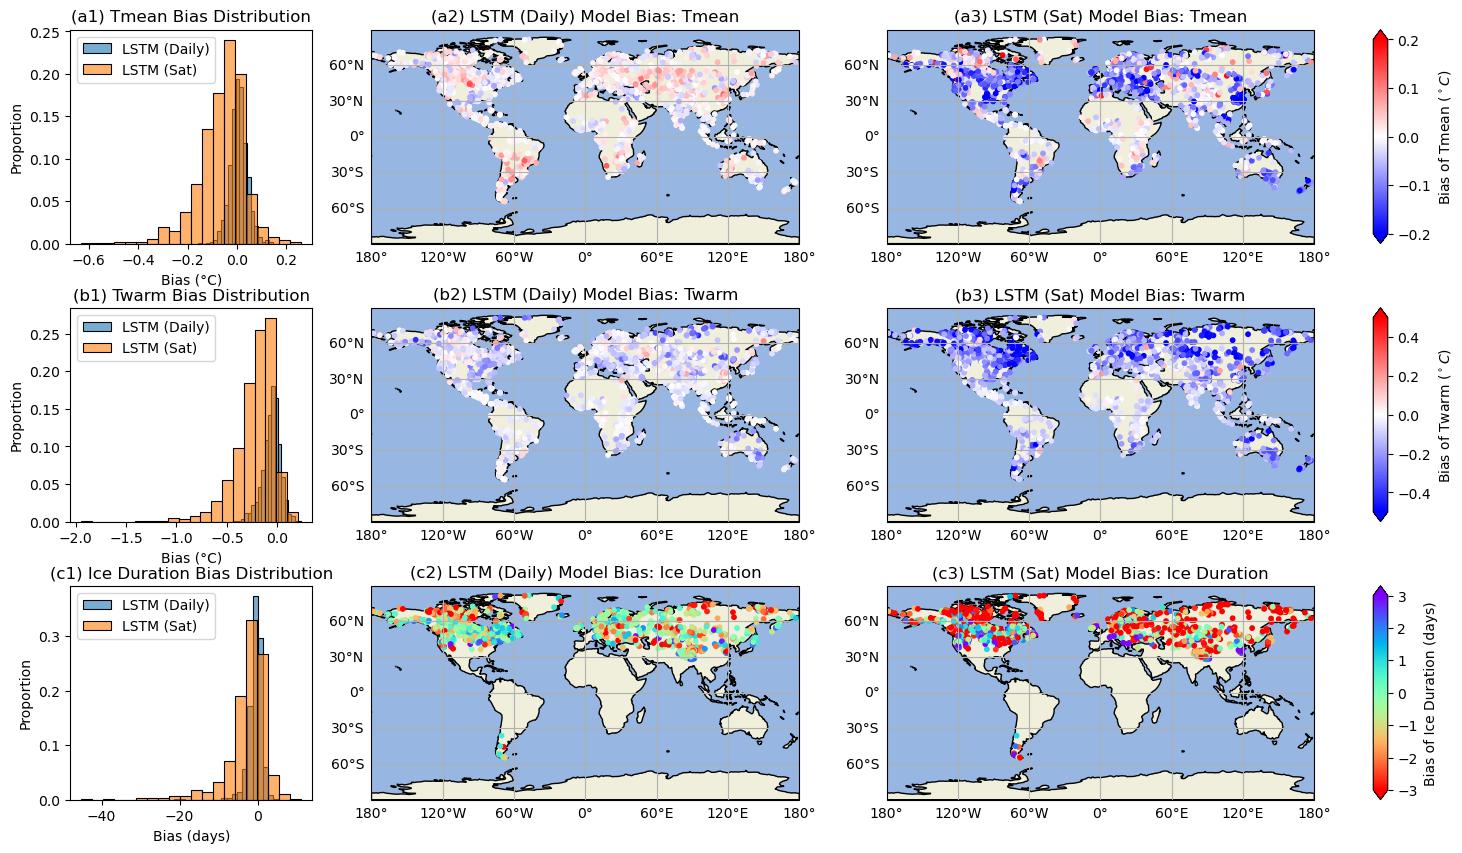

In [43]:
fig = plt.figure(figsize=(17, 10))
nt_proj = ccrs.PlateCarree()

# Reproject once
stats_gdf_total = stats_gdf_total.to_crs(nt_proj)

# GridSpec layout: 3 rows (Tmean, Twarm, Tcold), 3 columns (histogram, map1, map2)
gs = gridspec.GridSpec(3, 4, width_ratios=[0.5, 1, 1, 0.03], height_ratios=[1, 1, 1], wspace=0.1, hspace=0.3)

# Helper for maps
def add_map(ax, column, cmap, vmin, vmax, title, lake_ids=cci_lake_list):
    ax.add_feature(cartopy.feature.OCEAN, zorder=0)
    ax.add_feature(cartopy.feature.LAND, zorder=0, edgecolor='black')
    ax.set_global()
    gl = ax.gridlines(crs=nt_proj, draw_labels=True)
    gl.top_labels = False
    gl.right_labels = False
    stats_gdf_total.loc[lake_ids].dropna(subset=[column]).plot(
        column=column,
        markersize=10,
        cmap=cmap,
        vmin=vmin,
        vmax=vmax,
        legend=False,
        ax=ax,
    )
    ax.set_title(title, fontsize=12, loc='center')

# Histogram style
hist_kws = {
    "stat": "proportion",
    "bins": 20,
    "element": "bars",
    "fill": True,
    "common_norm": False,
    "alpha": 0.6
}

# --- Row 1: Tmean ---
# Histogram

vmin = -0.2
vmax = 0.2

ax0 = fig.add_subplot(gs[0, 0])
sns.histplot(data=stats_gdf_total, x="lstm_bias_mean", ax=ax0, color="tab:blue", label="LSTM (Daily)", **hist_kws)
sns.histplot(data=stats_gdf_total, x="lstm_satbias_mean", ax=ax0, color="tab:orange", label="LSTM (Sat)", **hist_kws)
ax0.set_title("(a1) Tmean Bias Distribution")
ax0.set_xlabel("Bias (°C)")
ax0.set_ylabel("Proportion")
ax0.legend()

# Maps
ax1 = fig.add_subplot(gs[0, 1], projection=nt_proj)
ax2 = fig.add_subplot(gs[0, 2], projection=nt_proj)
add_map(ax1, "lstm_bias_mean", "bwr", vmin, vmax, "(a2) LSTM (Daily) Model Bias: Tmean")
add_map(ax2, "lstm_satbias_mean", "bwr", vmin, vmax, "(a3) LSTM (Sat) Model Bias: Tmean")

# Colorbar
cax1 = fig.add_subplot(gs[0, 3])
norm1 = mpl.colors.Normalize(vmin=vmin, vmax=vmax)
cb1 = mpl.colorbar.ColorbarBase(cax1, cmap="bwr", norm=norm1, orientation="vertical", extend='both')
cb1.set_label('Bias of Tmean $(^\\circ C)$')

# --- Row 2: Twarm ---
vmin = -0.5
vmax = 0.5

ax3 = fig.add_subplot(gs[1, 0])
sns.histplot(data=stats_gdf_total, x="lstm_bias_warmest_mean", ax=ax3, color="tab:blue", label="LSTM (Daily)", **hist_kws)
sns.histplot(data=stats_gdf_total, x="lstm_satbias_warmest_mean", ax=ax3, color="tab:orange", label="LSTM (Sat)", **hist_kws)
ax3.set_title("(b1) Twarm Bias Distribution")
ax3.set_xlabel("Bias (°C)")
ax3.legend()

ax4 = fig.add_subplot(gs[1, 1], projection=nt_proj)
ax5 = fig.add_subplot(gs[1, 2], projection=nt_proj)
add_map(ax4, "lstm_bias_warmest_mean", "bwr", vmin, vmax, "(b2) LSTM (Daily) Model Bias: Twarm")
add_map(ax5, "lstm_satbias_warmest_mean", "bwr", vmin, vmax, "(b3) LSTM (Sat) Model Bias: Twarm")

cax2 = fig.add_subplot(gs[1, 3])
norm2 = mpl.colors.Normalize(vmin=vmin, vmax=vmax)
cb2 = mpl.colorbar.ColorbarBase(cax2, cmap="bwr", norm=norm2, orientation="vertical", extend='both')
cb2.set_label('Bias of Twarm $(^\\circ C)$')

# --- Row 3: Ice Duration ---

vmin = -3
vmax = 3

ax6 = fig.add_subplot(gs[2, 0])
sns.histplot(data=stats_gdf_total.loc[ice_lake_ids], x="lstm_bias_ice_duration", ax=ax6, color="tab:blue", label="LSTM (Daily)", **hist_kws)
sns.histplot(data=stats_gdf_total.loc[ice_lake_ids], x="lstm_satbias_ice_duration", ax=ax6, color="tab:orange", label="LSTM (Sat)", **hist_kws)
ax6.set_title("(c1) Ice Duration Bias Distribution")
ax6.set_xlabel("Bias (days)")
ax6.legend()

ax7 = fig.add_subplot(gs[2, 1], projection=nt_proj)
ax8 = fig.add_subplot(gs[2, 2], projection=nt_proj)
add_map(ax7, "lstm_bias_ice_duration", "rainbow_r", vmin, vmax, "(c2) LSTM (Daily) Model Bias: Ice Duration", lake_ids=ice_lake_ids)
add_map(ax8, "lstm_satbias_ice_duration", "rainbow_r", vmin, vmax, "(c3) LSTM (Sat) Model Bias: Ice Duration", lake_ids=ice_lake_ids)

cax3 = fig.add_subplot(gs[2, 3])
norm3 = mpl.colors.Normalize(vmin=vmin, vmax=vmax)
cb3 = mpl.colorbar.ColorbarBase(cax3, cmap="rainbow_r", norm=norm3, orientation="vertical", extend='both')
cb3.set_label('Bias of Ice Duration (days)')

plt.tight_layout()  # leave space for colorbars

In [41]:
stats_gdf_total.loc[:, ["lstm_bias_mean", "lstm_satbias_mean", 
                        "lstm_bias_warmest_mean", "lstm_satbias_warmest_mean"]].describe()

,lstm_bias_mean,lstm_satbias_mean,lstm_bias_warmest_mean,lstm_satbias_warmest_mean
count,2016.000000,2016.000000,2016.000000,2016.000000
mean,0.006730,-0.058183,-0.059291,-0.214387
std,0.034545,0.092866,0.089531,0.195504
min,-0.156243,-0.629262,-0.425633,-1.944283
25%,-0.013780,-0.106258,-0.108986,-0.304430
50%,0.006531,-0.043348,-0.048760,-0.175397
75%,0.026654,0.000523,-0.002408,-0.081404
max,0.145289,0.260600,0.239751,0.205314


In [42]:
stats_gdf_total.loc[ice_lake_ids, ["lstm_bias_ice_duration", "lstm_satbias_ice_duration"]].describe()

,lstm_bias_ice_duration,lstm_satbias_ice_duration
count,1324.000000,1324.000000
mean,-0.585085,-2.525007
std,1.726710,5.243199
min,-21.319048,-45.185714
25%,-1.352381,-3.982143
50%,-0.371429,-1.385714
75%,0.444048,0.457143
max,5.357143,11.200000


In [15]:
fig.savefig("../figs/lstm_model_biases.png", dpi = 300, bbox_inches='tight')

# Bias change histograms

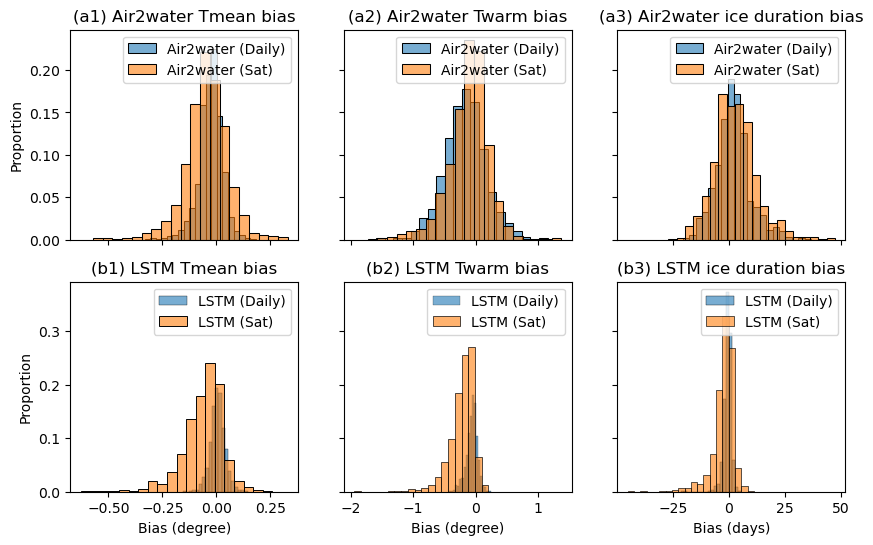

In [39]:
fig, axes = plt.subplots(2,3, figsize = (10,6), 
                         sharey = "row", 
                         sharex = "col",
                        )

# Histogram style
hist_kws = {
    "stat": "proportion",
    "bins": 20,
    "element": "bars",
    "fill": True,
    "common_norm": False,
    "alpha": 0.6
}

# first row: air2water
ax1 = axes[0,0]
ax2 = axes[0,1]
ax3 = axes[0,2]

sns.histplot(data=stats_gdf_total, x="a2w_bias_mean", ax=ax1, color="tab:blue", label="Air2water (Daily)", **hist_kws)
sns.histplot(data=stats_gdf_total, x="a2w_satbias_mean", ax=ax1, color="tab:orange", label="Air2water (Sat)", **hist_kws)
ax1.set_title("(a1) Air2water Tmean bias")
ax1.set_xlabel("Bias (degree)")
ax1.legend()

sns.histplot(data=stats_gdf_total, x="a2w_bias_warmest_mean", ax=ax2, color="tab:blue", label="Air2water (Daily)", **hist_kws)
sns.histplot(data=stats_gdf_total, x="a2w_satbias_warmest_mean", ax=ax2, color="tab:orange", label="Air2water (Sat)", **hist_kws)
ax2.set_title("(a2) Air2water Twarm bias")
ax2.set_xlabel("Bias (degree)")
ax2.legend()

sns.histplot(data=stats_gdf_total.loc[ice_lake_ids], x="a2w_bias_ice_duration", ax=ax3, color="tab:blue", label="Air2water (Daily)", **hist_kws)
sns.histplot(data=stats_gdf_total.loc[ice_lake_ids], x="a2w_satbias_ice_duration", ax=ax3, color="tab:orange", label="Air2water (Sat)", **hist_kws)
ax3.set_title("(a3) Air2water ice duration bias")
ax3.set_xlabel("Bias (days)")
ax3.legend()

# second row: LSTM
ax4 = axes[1,0]
ax5 = axes[1,1]
ax6 = axes[1,2]

sns.histplot(data=stats_gdf_total, x="lstm_bias_mean", ax=ax4, color="tab:blue", label="LSTM (Daily)", **hist_kws)
sns.histplot(data=stats_gdf_total, x="lstm_satbias_mean", ax=ax4, color="tab:orange", label="LSTM (Sat)", **hist_kws)
ax4.set_title("(b1) LSTM Tmean bias")
ax4.set_xlabel("Bias (degree)")
ax4.legend()

sns.histplot(data=stats_gdf_total, x="lstm_bias_warmest_mean", ax=ax5, color="tab:blue", label="LSTM (Daily)", **hist_kws)
sns.histplot(data=stats_gdf_total, x="lstm_satbias_warmest_mean", ax=ax5, color="tab:orange", label="LSTM (Sat)", **hist_kws)
ax5.set_title("(b2) LSTM Twarm bias")
ax5.set_xlabel("Bias (degree)")
ax5.legend()

sns.histplot(data=stats_gdf_total.loc[ice_lake_ids], x="lstm_bias_ice_duration", ax=ax6, color="tab:blue", label="LSTM (Daily)", **hist_kws)
sns.histplot(data=stats_gdf_total.loc[ice_lake_ids], x="lstm_satbias_ice_duration", ax=ax6, color="tab:orange", label="LSTM (Sat)", **hist_kws)
ax6.set_title("(b3) LSTM ice duration bias")
ax6.set_xlabel("Bias (days)")
ax6.legend()

In [21]:
fig.savefig("../figs/model_biases_histogram.png", dpi = 300, bbox_inches='tight')

# Attribute cloud bias changes

/tmp/ipykernel_4108137/3239084515.py:91: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()  # leave space for colorbars


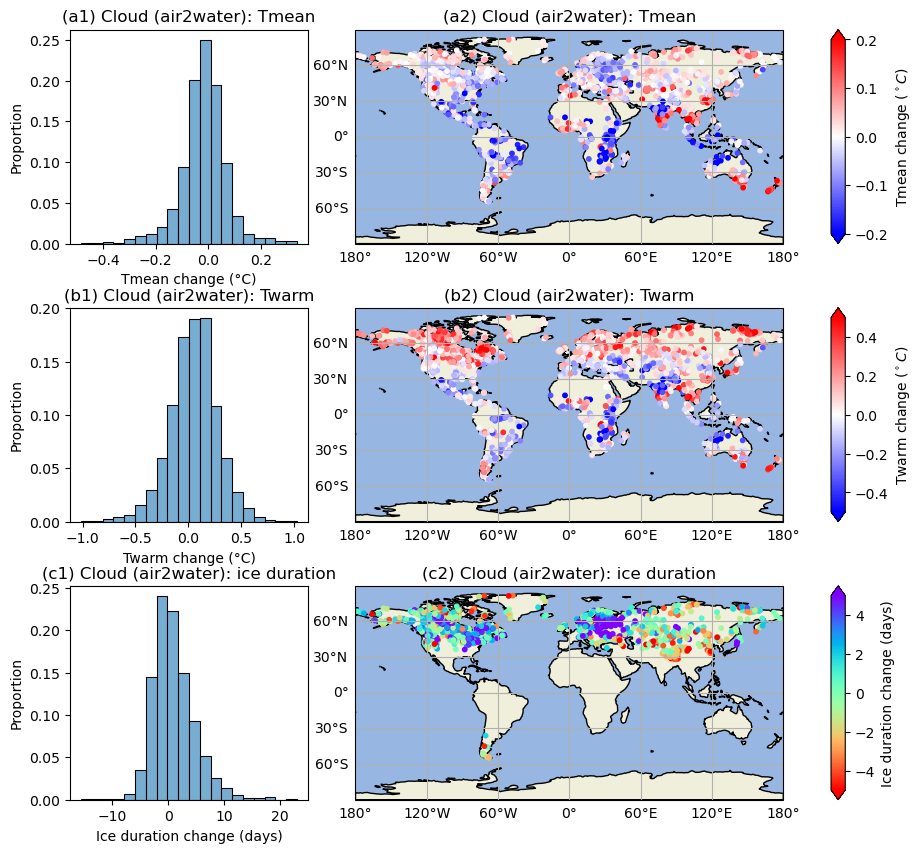

In [31]:
fig = plt.figure(figsize=(10, 10))
nt_proj = ccrs.PlateCarree()

# Reproject once
# stats_gdf_val = stats_gdf_val.to_crs(nt_proj)
# stats_gdf_train = stats_gdf_train.to_crs(nt_proj)
stats_gdf_total = stats_gdf_total.to_crs(nt_proj)

# GridSpec layout: 3 rows (Tmean, Twarm, Tcold), 3 columns (histogram, map1, map2)
gs = gridspec.GridSpec(3, 3, width_ratios=[0.5, 1, 0.03], height_ratios=[1, 1, 1], wspace=0.1, hspace=0.3)

# Helper for maps
def add_map(ax, column, cmap, vmin, vmax, title, lake_ids=cci_lake_list):
    ax.add_feature(cartopy.feature.OCEAN, zorder=0)
    ax.add_feature(cartopy.feature.LAND, zorder=0, edgecolor='black')
    ax.set_global()
    gl = ax.gridlines(crs=nt_proj, draw_labels=True)
    gl.top_labels = False
    gl.right_labels = False
    stats_gdf_total.loc[lake_ids].dropna(subset=[column]).plot(
        column=column,
        markersize=10,
        cmap=cmap,
        vmin=vmin,
        vmax=vmax,
        legend=False,
        ax=ax,
    )
    ax.set_title(title, fontsize=12, loc='center')

# Histogram style
hist_kws = {
    "stat": "proportion",
    "bins": 20,
    "element": "bars",
    "fill": True,
    "common_norm": False,
    "alpha": 0.6
}

# --- Row 1: Tmean ---

# Histogram
ax0 = fig.add_subplot(gs[0, 0])
sns.histplot(data=stats_gdf_total, x="a2w_diff_mean", ax=ax0, color="tab:blue", label="Air2water", **hist_kws)
ax0.set_title("(a1) Cloud (air2water): Tmean")
ax0.set_xlabel("Tmean change (°C)")
ax0.set_ylabel("Proportion")
# ax0.legend()

# Maps
ax1 = fig.add_subplot(gs[0, 1], projection=nt_proj)
add_map(ax1, "a2w_diff_mean", "bwr", -0.2, 0.2, "(a2) Cloud (air2water): Tmean")

# Colorbar
cax1 = fig.add_subplot(gs[0, 2])
norm1 = mpl.colors.Normalize(vmin=-0.2, vmax=0.2)
cb1 = mpl.colorbar.ColorbarBase(cax1, cmap="bwr", norm=norm1, orientation="vertical", extend='both')
cb1.set_label('Tmean change $(^\\circ C)$')

# --- Row 2: Twarm ---
ax3 = fig.add_subplot(gs[1, 0])
sns.histplot(data=stats_gdf_total, x="a2w_diff_warmest_mean", ax=ax3, color="tab:blue", label="Air2water", **hist_kws)
ax3.set_title("(b1) Cloud (air2water): Twarm")
ax3.set_xlabel("Twarm change (°C)")
# ax3.legend()

ax4 = fig.add_subplot(gs[1, 1], projection=nt_proj)
add_map(ax4, "a2w_diff_warmest_mean", "bwr", -0.5, 0.5, "(b2) Cloud (air2water): Twarm")

cax2 = fig.add_subplot(gs[1, 2])
norm2 = mpl.colors.Normalize(vmin=-0.5, vmax=0.5)
cb2 = mpl.colorbar.ColorbarBase(cax2, cmap="bwr", norm=norm2, orientation="vertical", extend='both')
cb2.set_label('Twarm change $(^\\circ C)$')

# --- Row 3: Ice Duration ---
ax6 = fig.add_subplot(gs[2, 0])
sns.histplot(data=stats_gdf_total.loc[ice_lake_ids], x="a2w_diff_ice_days_076", ax=ax6, color="tab:blue", label="Air2water", **hist_kws)
ax6.set_title("(c1) Cloud (air2water): ice duration")
ax6.set_xlabel("Ice duration change (days)")
# ax6.legend()

ax7 = fig.add_subplot(gs[2, 1], projection=nt_proj)
add_map(ax7, "a2w_diff_ice_days_076", "rainbow_r", -5, 5, "(c2) Cloud (air2water): ice duration", lake_ids=ice_lake_ids)

cax3 = fig.add_subplot(gs[2, 2])
norm3 = mpl.colors.Normalize(vmin=-5, vmax=5)
cb3 = mpl.colorbar.ColorbarBase(cax3, cmap="rainbow_r", norm=norm3, orientation="vertical", extend='both')
cb3.set_label('Ice duration change (days)')

plt.tight_layout()  # leave space for colorbars

In [32]:
fig.savefig("../figs/a2w_cloud_impact.png", dpi = 300, bbox_inches='tight')

/tmp/ipykernel_4108137/2989603726.py:91: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()  # leave space for colorbars


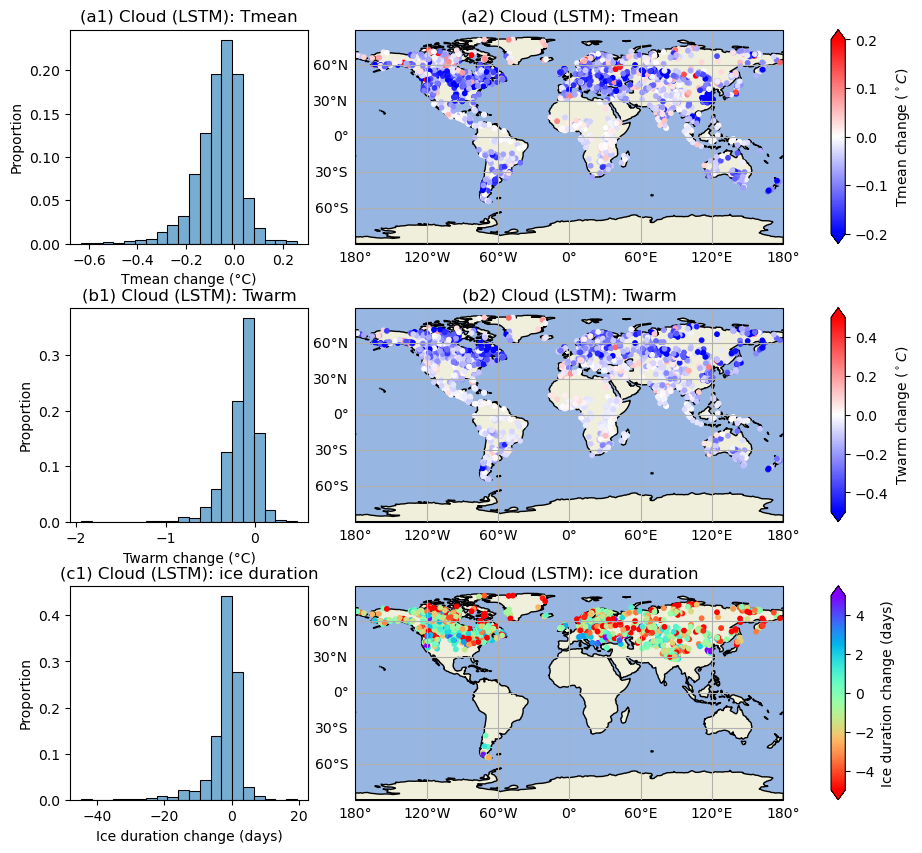

In [33]:
fig = plt.figure(figsize=(10, 10))
nt_proj = ccrs.PlateCarree()

# Reproject once
# stats_gdf_val = stats_gdf_val.to_crs(nt_proj)
# stats_gdf_train = stats_gdf_train.to_crs(nt_proj)
stats_gdf_total = stats_gdf_total.to_crs(nt_proj)

# GridSpec layout: 3 rows (Tmean, Twarm, Tcold), 3 columns (histogram, map1, map2)
gs = gridspec.GridSpec(3, 3, width_ratios=[0.5, 1, 0.03], height_ratios=[1, 1, 1], wspace=0.1, hspace=0.3)

# Helper for maps
def add_map(ax, column, cmap, vmin, vmax, title, lake_ids=cci_lake_list):
    ax.add_feature(cartopy.feature.OCEAN, zorder=0)
    ax.add_feature(cartopy.feature.LAND, zorder=0, edgecolor='black')
    ax.set_global()
    gl = ax.gridlines(crs=nt_proj, draw_labels=True)
    gl.top_labels = False
    gl.right_labels = False
    stats_gdf_total.loc[lake_ids].dropna(subset=[column]).plot(
        column=column,
        markersize=10,
        cmap=cmap,
        vmin=vmin,
        vmax=vmax,
        legend=False,
        ax=ax,
    )
    ax.set_title(title, fontsize=12, loc='center')

# Histogram style
hist_kws = {
    "stat": "proportion",
    "bins": 20,
    "element": "bars",
    "fill": True,
    "common_norm": False,
    "alpha": 0.6
}

# --- Row 1: Tmean ---

# Histogram
ax0 = fig.add_subplot(gs[0, 0])
sns.histplot(data=stats_gdf_total, x="lstm_diff_mean", ax=ax0, color="tab:blue", label="LSTM", **hist_kws)
ax0.set_title("(a1) Cloud (LSTM): Tmean")
ax0.set_xlabel("Tmean change (°C)")
ax0.set_ylabel("Proportion")
# ax0.legend()

# Maps
ax1 = fig.add_subplot(gs[0, 1], projection=nt_proj)
add_map(ax1, "lstm_diff_mean", "bwr", -0.2, 0.2, "(a2) Cloud (LSTM): Tmean")

# Colorbar
cax1 = fig.add_subplot(gs[0, 2])
norm1 = mpl.colors.Normalize(vmin=-0.2, vmax=0.2)
cb1 = mpl.colorbar.ColorbarBase(cax1, cmap="bwr", norm=norm1, orientation="vertical", extend='both')
cb1.set_label('Tmean change $(^\\circ C)$')

# --- Row 2: Twarm ---
ax3 = fig.add_subplot(gs[1, 0])
sns.histplot(data=stats_gdf_total, x="lstm_diff_warmest_mean", ax=ax3, color="tab:blue", label="LSTM", **hist_kws)
ax3.set_title("(b1) Cloud (LSTM): Twarm")
ax3.set_xlabel("Twarm change (°C)")
# ax3.legend()

ax4 = fig.add_subplot(gs[1, 1], projection=nt_proj)
add_map(ax4, "lstm_diff_warmest_mean", "bwr", -0.5, 0.5, "(b2) Cloud (LSTM): Twarm")

cax2 = fig.add_subplot(gs[1, 2])
norm2 = mpl.colors.Normalize(vmin=-0.5, vmax=0.5)
cb2 = mpl.colorbar.ColorbarBase(cax2, cmap="bwr", norm=norm2, orientation="vertical", extend='both')
cb2.set_label('Twarm change $(^\\circ C)$')

# --- Row 3: Ice Duration ---
ax6 = fig.add_subplot(gs[2, 0])
sns.histplot(data=stats_gdf_total.loc[ice_lake_ids], x="lstm_diff_ice_days_076", ax=ax6, color="tab:blue", label="LSTM", **hist_kws)
ax6.set_title("(c1) Cloud (LSTM): ice duration")
ax6.set_xlabel("Ice duration change (days)")
# ax6.legend()

ax7 = fig.add_subplot(gs[2, 1], projection=nt_proj)
add_map(ax7, "lstm_diff_ice_days_076", "rainbow_r", -5, 5, "(c2) Cloud (LSTM): ice duration", lake_ids=ice_lake_ids)

cax3 = fig.add_subplot(gs[2, 2])
norm3 = mpl.colors.Normalize(vmin=-5, vmax=5)
cb3 = mpl.colorbar.ColorbarBase(cax3, cmap="rainbow_r", norm=norm3, orientation="vertical", extend='both')
cb3.set_label('Ice duration change (days)')

plt.tight_layout()  # leave space for colorbars

In [34]:
fig.savefig("../figs/lstm_cloud_impact.png", dpi = 300, bbox_inches='tight')

In [11]:
stats_gdf_total.sort_values(["lstm_cloudbias_warmest_mean"]).head(5)

,NAME,COUNTRY,LAT CENTRE,LON CENTRE,MAX DISTANCE TO LAND (KM),LAT MIN BOX,LAT MAX BOX,LON MIN BOX,LON MAX BOX,ID in GLOBOLAKES 1000 MASK,...,a2w_bias_ice_duration,lstm_bias_mean,lstm_bias_warmest_mean,lstm_bias_ice_duration,a2w_satbias_mean,a2w_satbias_warmest_mean,a2w_satbias_ice_duration,lstm_satbias_mean,lstm_satbias_warmest_mean,lstm_satbias_ice_duration
cci_lake_id,,,,,,,,,,,,,,,,,,,,,
338,Kamchatka river,Russian Federation,56.4236,162.7264,6.3,56.1875,56.5792,162.3625,163.1458,NaN,...,11.080952,0.004479,0.000134,0.457143,-0.207904,-0.978236,13.261905,-0.407914,-1.944283,-3.757143
300004655,lac Duquet,Canada,60.3653,-75.3181,2.5,60.2458,60.4292,-75.4042,-75.1625,NaN,...,-6.685714,0.017010,0.165085,-2.195238,0.069000,0.185836,-10.714286,-0.096265,-1.020550,-16.604762
300011226,Ulakhan-Kelyuyekyan,Russian Federation,69.1375,152.8292,3.0,69.0625,69.2042,152.6125,152.9458,NaN,...,-11.757143,0.039526,0.007513,-5.371429,0.139869,0.103819,-10.790476,-0.201841,-1.169219,-3.442857
300000465,lac Nachicapau,Canada,56.7208,-67.9597,2.1,56.5375,56.7958,-68.4958,-67.8292,NaN,...,4.319048,-0.020398,-0.083969,0.309524,-0.035671,0.066619,5.414286,-0.413768,-1.239634,1.661905
300005890,Sango Brook,Canada,55.9042,-61.4458,1.9,55.8375,55.9708,-61.5792,-61.2125,NaN,...,5.180952,-0.010090,0.018927,3.157143,0.002383,-0.089787,2.028571,-0.303297,-1.034217,-6.147619


In [12]:
stats_gdf_total.loc[:, ["a2w_cloudbias_mean", "lstm_cloudbias_mean"]].describe()

,a2w_diff_mean,lstm_diff_mean
count,2016.000000,2016.000000
mean,-0.017128,-0.064914
std,0.085618,0.094149
min,-0.482972,-0.632714
25%,-0.057760,-0.110864
50%,-0.013230,-0.049795
75%,0.028637,-0.004750
max,0.336430,0.258168


In [13]:
stats_gdf_total.loc[:, ["a2w_cloudbias_warmest_mean", "lstm_cloudbias_warmest_mean"]].describe()

,a2w_diff_warmest_mean,lstm_diff_warmest_mean
count,2016.000000,2016.000000
mean,0.050909,-0.155097
std,0.227498,0.185351
min,-1.014347,-1.944417
25%,-0.084964,-0.240484
50%,0.056829,-0.116339
75%,0.189420,-0.035625
max,1.027510,0.468112


In [14]:
stats_gdf_total.loc[ice_lake_ids, ["a2w_cloudbias_ice_days_076", "lstm_cloudbias_ice_days_076"]].describe()

,a2w_diff_ice_days_076,lstm_diff_ice_days_076
count,1325.000000,1325.000000
mean,1.015087,-1.935788
std,3.726208,5.013348
min,-15.538095,-44.680952
25%,-1.433333,-3.000000
50%,0.476190,-0.952381
75%,2.871429,0.585714
max,23.000000,19.319048
